- https://github.com/j-min/tf_tutorial_plus/blob/master/RNN_seq2seq/legacy_seq2seq/01_pure_seq2seq.ipynb

## Import Modules

In [3]:
# To plot learning curve graph
%matplotlib inline
import matplotlib.pyplot as plt

# for pretty print
from pprint import pprint

# for tokenizer
import re

# for word counter in vocabulary dictionary
from collections import Counter

# TensorFlow of Course :)
import tensorflow as tf

# The paths of RNNCell or rnn functions are too long.
from tensorflow.contrib.legacy_seq2seq.python.ops import *
from tensorflow.contrib.rnn.python.ops.core_rnn_cell_impl import *

In [65]:
from tensorflow.contrib.legacy_seq2seq import rnn_decoder, \
embedding_rnn_decoder, \
embedding_rnn_seq2seq, \
attention_decoder, embedding_attention_decoder, \
embedding_attention_seq2seq

## Sample training data

In [4]:
enc_sentence_length = 10
dec_sentence_length = 10
batch_size = 4

In [5]:
input_batches = [
    ['Hi What is your name?', 'Nice to meet you!'],
    ['Which programming language do you use?', 'See you later.'],
    ['Where do you live?', 'What is your major?'],
    ['What do you want to drink?', 'What is your favorite beer?']]

target_batches = [
    ['Hi this is Jaemin.', 'Nice to meet you too!'],
    ['I like Python.', 'Bye Bye.'],
    ['I live in Seoul, South Korea.', 'I study industrial engineering.'],
    ['Beer please!', 'Leffe brown!']]

In [6]:
all_input_sentences = []
for input_batch in input_batches:
    all_input_sentences.extend(input_batch)
all_input_sentences

['Hi What is your name?',
 'Nice to meet you!',
 'Which programming language do you use?',
 'See you later.',
 'Where do you live?',
 'What is your major?',
 'What do you want to drink?',
 'What is your favorite beer?']

In [7]:
all_target_sentences = []
for target_batch in target_batches:
    all_target_sentences.extend(target_batch)
all_target_sentences

['Hi this is Jaemin.',
 'Nice to meet you too!',
 'I like Python.',
 'Bye Bye.',
 'I live in Seoul, South Korea.',
 'I study industrial engineering.',
 'Beer please!',
 'Leffe brown!']

## NLP helper functions

In [8]:
def tokenizer(sentence):
    tokens = re.findall(r"[\w]+|[^\s\w]", sentence)
    return tokens

# Example
tokenizer('Hello world?? "sdfs%@#%')

['Hello', 'world', '?', '?', '"', 'sdfs', '%', '@', '#', '%']

In [9]:
def build_vocab(sentences, is_target=False, max_vocab_size=None):
    word_counter = Counter()
    word2id = dict()
    id2word = dict()
    
    for sentence in sentences:
        tokens = tokenizer(sentence)
        word_counter.update(tokens)
        
    if max_vocab_size is None:
        max_vocab_size = len(word_counter)
    
    if is_target:
        word2id['_GO'] = 0
        word2id['_PAD'] = 1
        vocab_idx = 2
        for key, value in word_counter.most_common(max_vocab_size):
            word2id[key] = vocab_idx
            vocab_idx += 1
    else:
        word2id['_PAD'] = 0
        vocab_idx = 1
        for key, value in word_counter.most_common(max_vocab_size):
            word2id[key] = vocab_idx
            vocab_idx += 1
            
    for key, value in word2id.items():
        id2word[value] = key
            
    return word2id, id2word, max_vocab_size

In [10]:
# Example
pprint(build_vocab(all_input_sentences))
print('\n')
pprint(build_vocab(all_target_sentences, is_target=True))

({'!': 12,
  '.': 19,
  '?': 1,
  'Hi': 8,
  'Nice': 10,
  'See': 17,
  'What': 3,
  'Where': 20,
  'Which': 13,
  '_PAD': 0,
  'beer': 26,
  'do': 6,
  'drink': 24,
  'favorite': 25,
  'is': 4,
  'language': 15,
  'later': 18,
  'live': 21,
  'major': 22,
  'meet': 11,
  'name': 9,
  'programming': 14,
  'to': 7,
  'use': 16,
  'want': 23,
  'you': 2,
  'your': 5},
 {0: '_PAD',
  1: '?',
  2: 'you',
  3: 'What',
  4: 'is',
  5: 'your',
  6: 'do',
  7: 'to',
  8: 'Hi',
  9: 'name',
  10: 'Nice',
  11: 'meet',
  12: '!',
  13: 'Which',
  14: 'programming',
  15: 'language',
  16: 'use',
  17: 'See',
  18: 'later',
  19: '.',
  20: 'Where',
  21: 'live',
  22: 'major',
  23: 'want',
  24: 'drink',
  25: 'favorite',
  26: 'beer'},
 26)


({'!': 3,
  ',': 20,
  '.': 2,
  'Beer': 26,
  'Bye': 5,
  'Hi': 6,
  'I': 4,
  'Jaemin': 9,
  'Korea': 22,
  'Leffe': 28,
  'Nice': 10,
  'Python': 16,
  'Seoul': 19,
  'South': 21,
  '_GO': 0,
  '_PAD': 1,
  'brown': 29,
  'engineering': 25,
  'in': 18,

In [11]:
enc_word2id, enc_id2word, enc_vocab_size = build_vocab(all_input_sentences)
dec_word2id, dec_id2word, dec_vocab_size = build_vocab(all_target_sentences, is_target=True)

In [12]:
for token in tokenizer('Nice to meet you!'):
    print(token, enc_word2id[token])

Nice 10
to 7
meet 11
you 2
! 12


In [13]:
def sent2ids(sent, vocab, max_sentence_length, is_target=False):
    tokens = tokenizer(sent)
    current_length = len(tokens)
    pad_length = max_sentence_length - current_length
    if is_target:
        return [0] + [vocab[token] for token in tokens] + [1] * pad_length
    else:
        return [vocab[token] for token in tokens] + [0] * pad_length, current_length

In [14]:
# Enc Example
print('Hi What is your name?')
print(sent2ids('Hi What is your name?', vocab=enc_word2id, max_sentence_length=enc_sentence_length, is_target=False))

# Dec Example
print('Hi this is Jaemin.')
print(sent2ids('Hi this is Jaemin.', vocab=dec_word2id, max_sentence_length=dec_sentence_length, is_target=True))

Hi What is your name?
([8, 3, 4, 5, 9, 1, 0, 0, 0, 0], 6)
Hi this is Jaemin.
[0, 6, 7, 8, 9, 2, 1, 1, 1, 1, 1]


In [15]:
def ids2sent(ids, reverse_vocab):
    return " ".join([reverse_vocab[i] for i in ids])

In [16]:
ids2sent([0, 6, 7, 8, 9, 2, 1, 1, 1, 1, 1], reverse_vocab=dec_id2word)

'_GO Hi this is Jaemin . _PAD _PAD _PAD _PAD _PAD'

## Hyperparameters

In [17]:
n_epoch = 2000
n_enc_layer = 3
n_dec_layer = 3
hidden_size = 30

enc_emb_size = 30 #enc_vocab_size
dec_emb_size = 30 # dec_vocab_size

## Build Graph

In [18]:
tf.reset_default_graph()

enc_inputs = tf.placeholder(
    tf.int32,
    shape=[None, enc_sentence_length],
    name='input_sentences')

sequence_lengths = tf.placeholder(
    tf.int32,
    shape=[None],
    name='sentences_length')

dec_inputs = tf.placeholder(
    tf.int32,
    shape=[None, dec_sentence_length+1],
    name='output_sentences')

# batch major => time major
enc_inputs_t = tf.transpose(enc_inputs, perm=[1,0])
dec_inputs_t = tf.transpose(dec_inputs, perm=[1,0])

with tf.device('/cpu:0'):
    enc_Wemb = tf.get_variable('enc_word_emb',
        initializer=tf.random_uniform([enc_vocab_size+1, enc_emb_size]))
    dec_Wemb = tf.get_variable('dec_word_emb',
        initializer=tf.random_uniform([dec_vocab_size+2, dec_emb_size]))
    dec_out_W = tf.get_variable('dec_out_W',
        initializer=tf.random_uniform([hidden_size, dec_vocab_size+2]))
    dec_out_b = tf.get_variable('dec_out_b',
        initializer=tf.random_uniform([dec_vocab_size+2]))
    
with tf.variable_scope('encoder'):
    enc_emb_inputs = tf.nn.embedding_lookup(enc_Wemb, enc_inputs_t)
    
    # enc_emb_inputs:
    #     list(enc_sent_len) of tensor[batch_size x embedding_size]
    # Because `static_rnn` takes list inputs
    enc_emb_inputs = tf.unstack(enc_emb_inputs)
    
    enc_cell = BasicRNNCell(hidden_size)
    
    # enc_sent_len x batch_size x embedding_size
    enc_outputs, enc_last_state = tf.contrib.rnn.static_rnn(
        cell=enc_cell,
        inputs=enc_emb_inputs,
        sequence_length=sequence_lengths,
        dtype=tf.float32)

dec_outputs = []
dec_predictions = []
with tf.variable_scope('decoder') as scope:
    dec_cell = BasicRNNCell(hidden_size)
    
    for i in range(dec_sentence_length+1):
        if i == 0:
            input_ = tf.nn.embedding_lookup(dec_Wemb, dec_inputs_t[i])
            state = enc_last_state
        else:
            scope.reuse_variables()
            input_ = tf.nn.embedding_lookup(dec_Wemb, dec_prediction)
        
        # dec_output: batch_size x dec_vocab_size+2
        # state:      batch_size x hidden_size
        dec_output, state = dec_cell(input_, state)
        dec_output = tf.nn.xw_plus_b(dec_output, dec_out_W, dec_out_b)
        
        # dec_prediction: batch_size x 1
        dec_prediction = tf.argmax(dec_output, axis=1)
        
        dec_outputs.append(dec_output)
        dec_predictions.append(dec_prediction)

# predictions: [batch_size x dec_sentence_lengths+1]
predictions = tf.transpose(tf.stack(dec_predictions), [1,0])

# labels & logits: [dec_sentence_length+1 x batch_size x dec_vocab_size+2]
labels = tf.one_hot(dec_inputs_t, dec_vocab_size+2)
logits = tf.stack(dec_outputs)
        
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=labels, logits=logits))

# training_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
training_op = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss)

## Run Graph

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    for epoch in range(n_epoch):
        
        all_preds = []
        epoch_loss = 0
        for input_batch, target_batch in zip(input_batches, target_batches):
            input_token_indices = []
            target_token_indices = []
            sentence_lengths = []
            
            for input_sent in input_batch:
                input_sent, sent_len = sent2ids(input_sent, vocab=enc_word2id, max_sentence_length=enc_sentence_length)
                input_token_indices.append(input_sent)
                sentence_lengths.append(sent_len)

            for target_sent in target_batch:
                target_token_indices.append(
                    sent2ids(target_sent, vocab=dec_word2id, max_sentence_length=dec_sentence_length, is_target=True))
            
            # Evaluate three operations in the graph
            # => predictions, loss, training_op(optimzier)
            batch_preds, batch_loss, _ = sess.run(
                [predictions, loss, training_op],
                feed_dict={
                    enc_inputs: input_token_indices,
                    sequence_lengths: sentence_lengths,
                    dec_inputs: target_token_indices
                })
            loss_history.append(batch_loss)
            epoch_loss += batch_loss
            all_preds.append(batch_preds)
            
        # Logging every 400 epochs
        if epoch % 400 == 0:
            print('Epoch', epoch)
            for input_batch, target_batch, batch_preds in zip(input_batches, target_batches, all_preds):
                for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                    print('\t', input_sent)
                    print('\t => ', ids2sent(pred, reverse_vocab=dec_id2word))
                    print('\tCorrect answer:', target_sent)
            print('\tepoch loss: {:.2f}\n'.format(epoch_loss))

Epoch 0
	 Hi What is your name?
	 =>  to industrial too too too too too too too too too
	Correct answer: Hi this is Jaemin.
	 Nice to meet you!
	 =>  to Korea too too too too too too too too too
	Correct answer: Nice to meet you too!
	 Which programming language do you use?
	 =>  too is too too too too too too too too too
	Correct answer: I like Python.
	 See you later.
	 =>  too industrial too too too too too too too too too
	Correct answer: Bye Bye.
	 Where do you live?
	 =>  too is too too too too too too too too too
	Correct answer: I live in Seoul, South Korea.
	 What is your major?
	 =>  to I too too too too too too too too too
	Correct answer: I study industrial engineering.
	 What do you want to drink?
	 =>  to meet too too too too too too too too too
	Correct answer: Beer please!
	 What is your favorite beer?
	 =>  to industrial too too too too too too too too too
	Correct answer: Leffe brown!
	epoch loss: 15.64

Epoch 400
	 Hi What is your name?
	 =>  _GO I please ! _PAD _PAD

## Learning Curve

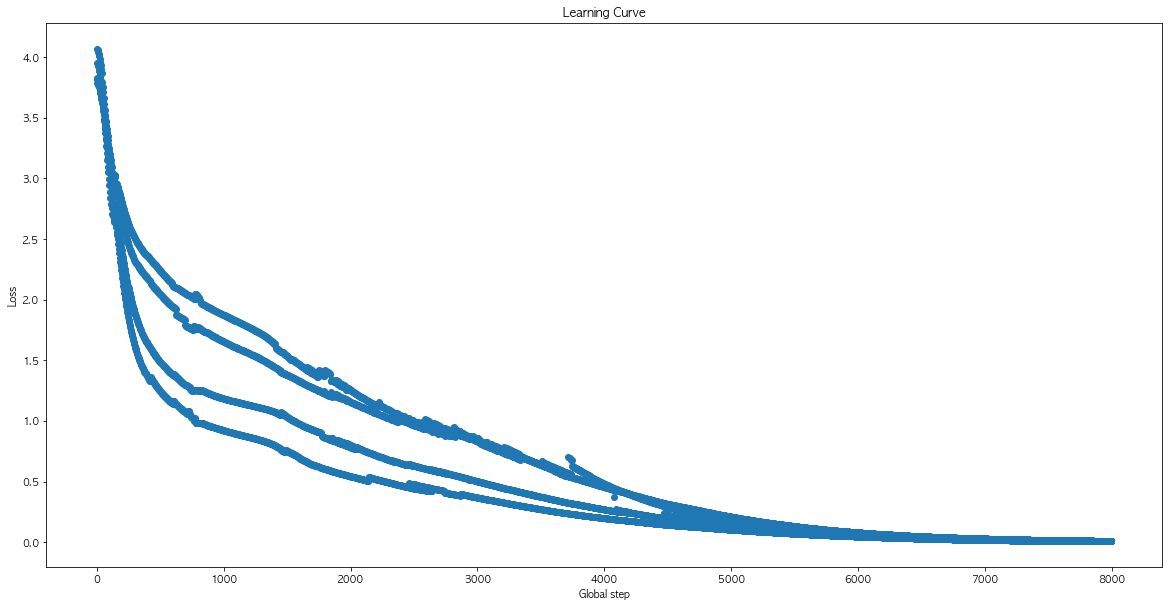

In [20]:
plt.figure(figsize=(20, 10))
plt.scatter(range(n_epoch * batch_size), loss_history)
plt.title('Learning Curve')
plt.xlabel('Global step')
plt.ylabel('Loss')
plt.show()

# 02_Proj_Emb_Wrapper
- https://github.com/j-min/tf_tutorial_plus/blob/master/RNN_seq2seq/legacy_seq2seq/02_Proj_Emb_Wrapper.ipynb

## Build Graph

In [21]:
tf.reset_default_graph()

enc_inputs = tf.placeholder(
    tf.int32,
    shape=[None, enc_sentence_length],
    name='input_sentences')

sequence_lengths = tf.placeholder(
    tf.int32,
    shape=[None],
    name='sentences_length')

dec_inputs = tf.placeholder(
    tf.int32,
    shape=[None, dec_sentence_length+1],
    name='output_sentences')

# batch major => time major
enc_inputs_t = tf.transpose(enc_inputs, perm=[1,0])
dec_inputs_t = tf.transpose(dec_inputs, perm=[1,0])

with tf.variable_scope('encoder'):
    enc_cell = BasicRNNCell(hidden_size)
    enc_cell = EmbeddingWrapper(enc_cell, enc_vocab_size+1, enc_emb_size)
    
    # enc_sent_len x batch_size x embedding_size
    enc_outputs, enc_last_state = tf.contrib.rnn.static_rnn(
        cell=enc_cell,
        inputs=tf.unstack(enc_inputs_t), 
        sequence_length=sequence_lengths,
        dtype=tf.float32)

dec_outputs = []
dec_predictions = []
with tf.variable_scope('decoder') as scope:
    dec_cell = BasicRNNCell(hidden_size)
    dec_cell = EmbeddingWrapper(dec_cell, dec_vocab_size+2, dec_emb_size)
    dec_cell = OutputProjectionWrapper(dec_cell, dec_vocab_size+2)
    
    for i in range(dec_sentence_length+1):
        if i == 0:
            input_ = dec_inputs_t[i]
            state = enc_last_state
        else:
            scope.reuse_variables()
            input_ = dec_prediction
        
        # dec_output: batch_size x dec_vocab_size+2
        # state:      batch_size x hidden_size
        dec_output, state = dec_cell(input_, state)
        
        # dec_prediction: batch_size x 1
        dec_prediction = tf.argmax(dec_output, axis=1)
        
        dec_outputs.append(dec_output)
        dec_predictions.append(dec_prediction)

# predictions: [batch_size x dec_sentence_lengths+1]
predictions = tf.transpose(tf.stack(dec_predictions), [1,0])

# labels & logits: [dec_sentence_length+1 x batch_size x dec_vocab_size+2]
labels = tf.one_hot(dec_inputs_t, dec_vocab_size+2)
logits = tf.stack(dec_outputs)
        
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=labels, logits=logits))

# training_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
training_op = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss)

## Run Graph

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    for epoch in range(n_epoch):
        
        all_preds = []
        epoch_loss = 0
        for input_batch, target_batch in zip(input_batches, target_batches):
            input_token_indices = []
            target_token_indices = []
            sentence_lengths = []
            
            for input_sent in input_batch:
                input_sent, sent_len = sent2ids(input_sent, vocab=enc_word2id, max_sentence_length=enc_sentence_length)
                input_token_indices.append(input_sent)
                sentence_lengths.append(sent_len)

            for target_sent in target_batch:
                target_token_indices.append(
                    sent2ids(target_sent, vocab=dec_word2id, max_sentence_length=dec_sentence_length, is_target=True))
            
            # Evaluate three operations in the graph
            # => predictions, loss, training_op(optimzier)
            batch_preds, batch_loss, _ = sess.run(
                [predictions, loss, training_op],
                feed_dict={
                    enc_inputs: input_token_indices,
                    sequence_lengths: sentence_lengths,
                    dec_inputs: target_token_indices
                })
            loss_history.append(batch_loss)
            epoch_loss += batch_loss
            all_preds.append(batch_preds)
            
        # Logging every 400 epochs
        if epoch % 400 == 0:
            print('Epoch', epoch)
            for input_batch, target_batch, batch_preds in zip(input_batches, target_batches, all_preds):
                for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                    print('\t', input_sent)
                    print('\t => ', ids2sent(pred, reverse_vocab=dec_id2word))
                    print('\tCorrect answer:', target_sent)
            print('\tepoch loss: {:.2f}\n'.format(epoch_loss))

Epoch 0
	 Hi What is your name?
	 =>  Hi please South too ! brown please South too ! brown
	Correct answer: Hi this is Jaemin.
	 Nice to meet you!
	 =>  Hi please South too ! brown please South too ! brown
	Correct answer: Nice to meet you too!
	 Which programming language do you use?
	 =>  live _GO Hi like Python Hi please South too ! brown
	Correct answer: I like Python.
	 See you later.
	 =>  study too ! ! I _PAD South too ! brown please
	Correct answer: Bye Bye.
	 Where do you live?
	 =>  live _GO Hi like this . Hi please South too !
	Correct answer: I live in Seoul, South Korea.
	 What is your major?
	 =>  live _GO Hi like Python Hi please South too ! brown
	Correct answer: I study industrial engineering.
	 What do you want to drink?
	 =>  live _GO Hi like Python Hi please South too ! brown
	Correct answer: Beer please!
	 What is your favorite beer?
	 =>  Hi like Python Hi please South too ! brown please South
	Correct answer: Leffe brown!
	epoch loss: 14.54

Epoch 400
	 Hi What i

# 03_rnn_decoder
- https://github.com/j-min/tf_tutorial_plus/blob/master/RNN_seq2seq/legacy_seq2seq/03_rnn_decoder.ipynb

In [24]:
def _extract_argmax_and_embed(embedding,
                              output_projection=None,
                              update_embedding=True):
    """Get a loop_function that extracts the previous symbol and embeds it.
    Args:
    embedding: embedding tensor for symbols.
    output_projection: None or a pair (W, B). If provided, each fed previous
      output will first be multiplied by W and added B.
    update_embedding: Boolean; if False, the gradients will not propagate
      through the embeddings.
      Returns:
      A loop function.
      """
    def loop_function(prev, _):
        if output_projection is not None:
            prev = tf.nn.xw_plus_b(prev, output_projection[0], output_projection[1])
        prev_symbol = tf.argmax(prev, 1)
        # Note that gradients will not propagate through the second parameter of
        # embedding_lookup.
        emb_prev = tf.nn.embedding_lookup(embedding, prev_symbol)
        if not update_embedding:
            emb_prev = tf.stop_gradient(emb_prev)
        return emb_prev

    return loop_function

In [29]:
tf.reset_default_graph()

enc_inputs = tf.placeholder(
    tf.int32,
    shape=[None, enc_sentence_length],
    name='input_sentences')

sequence_lengths = tf.placeholder(
    tf.int32,
    shape=[None],
    name='sentences_length')

dec_inputs = tf.placeholder(
    tf.int32,
    shape=[None, dec_sentence_length+1],
    name='output_sentences')

# batch_major => time_major
enc_inputs_t = tf.transpose(enc_inputs, [1,0])
dec_inputs_t = tf.transpose(dec_inputs, [1,0])

with tf.device('/cpu:0'):
    dec_Wemb = tf.get_variable('dec_word_emb',
        initializer=tf.random_uniform([dec_vocab_size+2, dec_emb_size]))
    
with tf.variable_scope('encoder'):
    enc_cell = BasicRNNCell(hidden_size)
    enc_cell = EmbeddingWrapper(enc_cell, enc_vocab_size+1, enc_emb_size)
    
    # enc_sent_len x batch_size x embedding_size
    enc_outputs, enc_last_state = tf.contrib.rnn.static_rnn(
        cell=enc_cell,
        inputs=tf.unstack(enc_inputs_t),
        sequence_length=sequence_lengths,
        dtype=tf.float32)

dec_outputs = []
dec_predictions = []
with tf.variable_scope('decoder'):
    dec_cell = BasicRNNCell(hidden_size)
    dec_cell = OutputProjectionWrapper(dec_cell, dec_vocab_size+2)
    
    # EmbeddingWrapper & tf.unstack(dec_inputs_t) raises dimension error
    dec_emb_inputs = tf.nn.embedding_lookup(dec_Wemb, dec_inputs_t)
    
    # dec_outputs: [dec_sent_len+1 x batch_size x hidden_size]
    dec_outputs, dec_last_state = rnn_decoder(
        decoder_inputs = tf.unstack(dec_emb_inputs),
        initial_state = enc_last_state,
        cell = dec_cell,
        loop_function = _extract_argmax_and_embed(dec_Wemb))

# predictions: [batch_size x dec_sentence_lengths+1]
predictions = tf.transpose(tf.argmax(tf.stack(dec_outputs), axis=-1), [1,0])

# labels & logits: [dec_sentence_length+1 x batch_size x dec_vocab_size+2]
labels = tf.one_hot(dec_inputs_t, dec_vocab_size+2)
logits = tf.stack(dec_outputs)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=labels, logits=logits))

# training_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
training_op = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss)

In [31]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    for epoch in range(n_epoch):
        
        all_preds = []
        epoch_loss = 0
        for input_batch, target_batch in zip(input_batches, target_batches):
            input_token_indices = []
            target_token_indices = []
            sentence_lengths = []
            
            for input_sent in input_batch:
                input_sent, sent_len = sent2ids(input_sent, vocab=enc_word2id, max_sentence_length=enc_sentence_length)
                input_token_indices.append(input_sent)
                sentence_lengths.append(sent_len)

            for target_sent in target_batch:
                target_token_indices.append(
                    sent2ids(target_sent, vocab=dec_word2id, max_sentence_length=dec_sentence_length, is_target=True))
            
            # Evaluate three operations in the graph
            # => predictions, loss, training_op(optimzier)
            batch_preds, batch_loss, _ = sess.run(
                [predictions, loss, training_op],
                feed_dict={
                    enc_inputs: input_token_indices,
                    sequence_lengths: sentence_lengths,
                    dec_inputs: target_token_indices
                })
            loss_history.append(batch_loss)
            epoch_loss += batch_loss
            all_preds.append(batch_preds)
            
        # Logging every 400 epochs
        if epoch % 400 == 0:
            print('Epoch', epoch)
            for input_batch, target_batch, batch_preds in zip(input_batches, target_batches, all_preds):
                for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                    print('\t', input_sent)
                    print('\t => ', ids2sent(pred, reverse_vocab=dec_id2word))
                    print('\tCorrect answer:', target_sent)
            print('\tepoch loss: {:.2f}\n'.format(epoch_loss))

Epoch 0
	 Hi What is your name?
	 =>  _GO ! to to to to to to to to to
	Correct answer: Hi this is Jaemin.
	 Nice to meet you!
	 =>  . ! to to to to to to to to to
	Correct answer: Nice to meet you too!
	 Which programming language do you use?
	 =>  _GO ! to to to to to to to to to
	Correct answer: I like Python.
	 See you later.
	 =>  _PAD ! to to to to to to to to to
	Correct answer: Bye Bye.
	 Where do you live?
	 =>  I _PAD ! to to to to to to to to
	Correct answer: I live in Seoul, South Korea.
	 What is your major?
	 =>  _GO ! study to to to to to to to to
	Correct answer: I study industrial engineering.
	 What do you want to drink?
	 =>  _GO ! study to to to to to to to to
	Correct answer: Beer please!
	 What is your favorite beer?
	 =>  Nice study to to to to to to to to to
	Correct answer: Leffe brown!
	epoch loss: 12.70

Epoch 400
	 Hi What is your name?
	 =>  _GO I live is engineering . _PAD _PAD _PAD _PAD _PAD
	Correct answer: Hi this is Jaemin.
	 Nice to meet you!
	 =>  _G

# 04_embedding_rnn_decoder.ipynb
- https://github.com/j-min/tf_tutorial_plus/blob/master/RNN_seq2seq/legacy_seq2seq/04_embedding_rnn_decoder.ipynb

In [34]:
tf.reset_default_graph()

enc_inputs = tf.placeholder(
    tf.int32,
    shape=[None, enc_sentence_length],
    name='input_sentences')

sequence_lengths = tf.placeholder(
    tf.int32,
    shape=[None],
    name='sentences_length')

dec_inputs = tf.placeholder(
    tf.int32,
    shape=[None, dec_sentence_length+1],
    name='output_sentences')

# batch_major => time_major
enc_inputs_t = tf.transpose(enc_inputs, [1,0])
dec_inputs_t = tf.transpose(dec_inputs, [1,0])
    
with tf.variable_scope('encoder'):
    enc_cell = BasicRNNCell(hidden_size)
    enc_cell = EmbeddingWrapper(enc_cell, enc_vocab_size+1, enc_emb_size)
    
    # enc_sent_len x batch_size x embedding_size
    enc_outputs, enc_last_state = tf.contrib.rnn.static_rnn(
        cell=enc_cell,
        inputs=tf.unstack(enc_inputs_t),
        sequence_length=sequence_lengths,
        dtype=tf.float32)

dec_outputs = []
dec_predictions = []
with tf.variable_scope('decoder'):
    dec_cell = BasicRNNCell(hidden_size)
    dec_cell = OutputProjectionWrapper(dec_cell, dec_vocab_size+2)
    
    # dec_outputs: [dec_sent_len+1 x batch_size x hidden_size]
    dec_outputs, dec_last_state = embedding_rnn_decoder(
        decoder_inputs=tf.unstack(dec_inputs_t),
        initial_state=enc_last_state,
        cell=dec_cell,
        num_symbols=dec_vocab_size+2,
        embedding_size=dec_emb_size,
        feed_previous=True)

        
# predictions: [batch_size x dec_sentence_lengths+1]
predictions = tf.transpose(tf.argmax(tf.stack(dec_outputs), axis=-1), [1,0])

# labels & logits: [dec_sentence_length+1 x batch_size x dec_vocab_size+2]
labels = tf.one_hot(dec_inputs_t, dec_vocab_size+2)
logits = tf.stack(dec_outputs)
        
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=labels, logits=logits))

# training_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
training_op = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss)


In [35]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    for epoch in range(n_epoch):
        
        all_preds = []
        epoch_loss = 0
        for input_batch, target_batch in zip(input_batches, target_batches):
            input_token_indices = []
            target_token_indices = []
            sentence_lengths = []
            
            for input_sent in input_batch:
                input_sent, sent_len = sent2ids(input_sent, vocab=enc_word2id, max_sentence_length=enc_sentence_length)
                input_token_indices.append(input_sent)
                sentence_lengths.append(sent_len)

            for target_sent in target_batch:
                target_token_indices.append(
                    sent2ids(target_sent, vocab=dec_word2id, max_sentence_length=dec_sentence_length, is_target=True))
            
            # Evaluate three operations in the graph
            # => predictions, loss, training_op(optimzier)
            batch_preds, batch_loss, _ = sess.run(
                [predictions, loss, training_op],
                feed_dict={
                    enc_inputs: input_token_indices,
                    sequence_lengths: sentence_lengths,
                    dec_inputs: target_token_indices
                })
            loss_history.append(batch_loss)
            epoch_loss += batch_loss
            all_preds.append(batch_preds)
            
        # Logging every 400 epochs
        if epoch % 400 == 0:
            print('Epoch', epoch)
            for input_batch, target_batch, batch_preds in zip(input_batches, target_batches, all_preds):
                for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                    print('\t', input_sent)
                    print('\t => ', ids2sent(pred, reverse_vocab=dec_id2word))
                    print('\tCorrect answer:', target_sent)
            print('\tepoch loss: {:.2f}\n'.format(epoch_loss))

Epoch 0
	 Hi What is your name?
	 =>  like Nice Python study . Korea Jaemin meet study Nice Nice
	Correct answer: Hi this is Jaemin.
	 Nice to meet you!
	 =>  Seoul ! _PAD Leffe too _GO Jaemin ! to I ,
	Correct answer: Nice to meet you too!
	 Which programming language do you use?
	 =>  like Beer _GO brown South Seoul _GO industrial brown live please
	Correct answer: I like Python.
	 See you later.
	 =>  Bye Nice _GO study ! Seoul brown live Jaemin Seoul to
	Correct answer: Bye Bye.
	 Where do you live?
	 =>  like like _GO brown too too Nice Nice _PAD _PAD Leffe
	Correct answer: I live in Seoul, South Korea.
	 What is your major?
	 =>  Seoul brown live you _PAD Leffe to Jaemin Seoul Jaemin !
	Correct answer: I study industrial engineering.
	 What do you want to drink?
	 =>  like like _GO brown too too Nice Nice _PAD _PAD Leffe
	Correct answer: Beer please!
	 What is your favorite beer?
	 =>  please in is is South , this meet Python engineering Beer
	Correct answer: Leffe brown!
	epoch 

# 05_embedding_rnn_seq2seq
- https://github.com/j-min/tf_tutorial_plus/blob/master/RNN_seq2seq/legacy_seq2seq/05_embedding_rnn_seq2seq.ipynb

In [40]:
tf.reset_default_graph()

enc_inputs = tf.placeholder(
    tf.int32,
    shape=[None, enc_sentence_length],
    name='input_sentences')

sequence_lengths = tf.placeholder(
    tf.int32,
    shape=[None],
    name='sentences_length')

dec_inputs = tf.placeholder(
    tf.int32,
    shape=[None, dec_sentence_length+1],
    name='output_sentences')

# batch_major => time_major
enc_inputs_t = tf.transpose(enc_inputs, [1,0])
dec_inputs_t = tf.transpose(dec_inputs, [1,0])

rnn_cell = BasicRNNCell(hidden_size)

with tf.variable_scope("embedding_rnn_seq2seq"):
    # dec_outputs: [dec_sent_len+1 x batch_size x hidden_size]
    dec_outputs, dec_last_state = embedding_rnn_seq2seq(
        encoder_inputs=tf.unstack(enc_inputs_t),
        decoder_inputs=tf.unstack(dec_inputs_t),
        cell=rnn_cell,
        num_encoder_symbols=enc_vocab_size+1,
        num_decoder_symbols=dec_vocab_size+2,
        embedding_size=enc_emb_size,
        feed_previous=True)

# predictions: [batch_size x dec_sentence_lengths+1]
predictions = tf.transpose(tf.argmax(tf.stack(dec_outputs), axis=-1), [1,0])

# labels & logits: [dec_sentence_length+1 x batch_size x dec_vocab_size+2]
labels = tf.one_hot(dec_inputs_t, dec_vocab_size+2)
logits = tf.stack(dec_outputs)
        
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=labels, logits=logits))

# training_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
training_op = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss)

In [41]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    for epoch in range(n_epoch):
        
        all_preds = []
        epoch_loss = 0
        for input_batch, target_batch in zip(input_batches, target_batches):
            input_token_indices = []
            target_token_indices = []
            sentence_lengths = []
            
            for input_sent in input_batch:
                input_sent, sent_len = sent2ids(input_sent, vocab=enc_word2id, max_sentence_length=enc_sentence_length)
                input_token_indices.append(input_sent)
                sentence_lengths.append(sent_len)

            for target_sent in target_batch:
                target_token_indices.append(
                    sent2ids(target_sent, vocab=dec_word2id, max_sentence_length=dec_sentence_length, is_target=True))
            
            # Evaluate three operations in the graph
            # => predictions, loss, training_op(optimzier)
            batch_preds, batch_loss, _ = sess.run(
                [predictions, loss, training_op],
                feed_dict={
                    enc_inputs: input_token_indices,
                    sequence_lengths: sentence_lengths,
                    dec_inputs: target_token_indices
                })
            loss_history.append(batch_loss)
            epoch_loss += batch_loss
            all_preds.append(batch_preds)
            
        # Logging every 400 epochs
        if epoch % 400 == 0:
            print('Epoch', epoch)
            for input_batch, target_batch, batch_preds in zip(input_batches, target_batches, all_preds):
                for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                    print('\t', input_sent)
                    print('\t => ', ids2sent(pred, reverse_vocab=dec_id2word))
                    print('\tCorrect answer:', target_sent)
            print('\tepoch loss: {:.2f}\n'.format(epoch_loss))

Epoch 0
	 Hi What is your name?
	 =>  Beer is , South meet Hi , Leffe Nice ! Nice
	Correct answer: Hi this is Jaemin.
	 Nice to meet you!
	 =>  Beer is , South , Leffe Nice ! Nice ! Nice
	Correct answer: Nice to meet you too!
	 Which programming language do you use?
	 =>  Jaemin is , South , Leffe Nice ! Nice ! Nice
	Correct answer: I like Python.
	 See you later.
	 =>  Beer is , study Nice ! _PAD like Bye in please
	Correct answer: Bye Bye.
	 Where do you live?
	 =>  Beer Hi , Leffe Nice ! Nice ! Nice ! Nice
	Correct answer: I live in Seoul, South Korea.
	 What is your major?
	 =>  Beer Hi , Hi too to Hi Leffe Leffe Beer study
	Correct answer: I study industrial engineering.
	 What do you want to drink?
	 =>  Jaemin is , South , Leffe Nice ! Nice ! Nice
	Correct answer: Beer please!
	 What is your favorite beer?
	 =>  Beer is , South , Leffe Nice ! Nice ! Nice
	Correct answer: Leffe brown!
	epoch loss: 13.33

Epoch 400
	 Hi What is your name?
	 =>  _GO I like is you _PAD _PAD _PAD _PA

# 06_attention_decoder
- https://github.com/j-min/tf_tutorial_plus/blob/master/RNN_seq2seq/legacy_seq2seq/06_attention_decoder.ipynb

In [43]:
def _extract_argmax_and_embed(embedding,
                              output_projection=None,
                              update_embedding=True):
    """Get a loop_function that extracts the previous symbol and embeds it.
    Args:
    embedding: embedding tensor for symbols.
    output_projection: None or a pair (W, B). If provided, each fed previous
      output will first be multiplied by W and added B.
    update_embedding: Boolean; if False, the gradients will not propagate
      through the embeddings.
      Returns:
      A loop function.
      """
    def loop_function(prev, _):
        if output_projection is not None:
            prev = tf.nn.xw_plus_b(prev, output_projection[0], output_projection[1])
        prev_symbol = tf.argmax(prev, 1)
        # Note that gradients will not propagate through the second parameter of
        # embedding_lookup.
        emb_prev = tf.nn.embedding_lookup(embedding, prev_symbol)
        if not update_embedding:
            emb_prev = tf.stop_gradient(emb_prev)
        return emb_prev

    return loop_function

In [51]:
tf.reset_default_graph()

enc_inputs = tf.placeholder(
    tf.int32,
    shape=[None, enc_sentence_length],
    name='input_sentences')

sequence_lengths = tf.placeholder(
    tf.int32,
    shape=[None],
    name='sentences_length')

dec_inputs = tf.placeholder(
    tf.int32,
    shape=[None, dec_sentence_length+1],
    name='output_sentences')

# batch_major => time_major
enc_inputs_t = tf.transpose(enc_inputs, [1,0])
dec_inputs_t = tf.transpose(dec_inputs, [1,0])

with tf.device('/cpu:0'):
    dec_Wemb = tf.get_variable('dec_word_emb',
        initializer=tf.random_uniform([dec_vocab_size+2, dec_emb_size]))
    
with tf.variable_scope('encoder'):
    enc_cell = BasicRNNCell(hidden_size)
    enc_cell = EmbeddingWrapper(enc_cell, enc_vocab_size+1, enc_emb_size)
    
    # enc_sent_len x batch_size x embedding_size
    enc_outputs, enc_last_state = tf.contrib.rnn.static_rnn(
        cell=enc_cell,
        inputs=tf.unstack(enc_inputs_t),
        sequence_length=sequence_lengths,
        dtype=tf.float32)

top_states = []
with tf.variable_scope('attention'):
    # top_states: enc_sent_len x [batch_size x 1 x embedding_size]
    #           list of enc_output of each encoder step
    # enc_outputs has length of enc_sent_len (= max_enc_len)
    for enc_output in enc_outputs:
        top_states.append(tf.reshape(enc_output, [-1, 1, enc_cell.output_size]))

    # attention_states: [batch_size x enc_sent_len x embedding_size]
    attention_states = tf.concat(top_states, 1)
    
dec_outputs = []
dec_predictions = []
with tf.variable_scope('decoder'):
    dec_cell = BasicRNNCell(hidden_size)
    dec_cell = OutputProjectionWrapper(dec_cell, dec_vocab_size+2)
    
    # EmbeddingWrapper & tf.unstack(dec_inputs_t) raises dimension error
    dec_emb_inputs = tf.nn.embedding_lookup(dec_Wemb, dec_inputs_t)
    
    # dec_outputs: [dec_sent_len+1 x batch_size x hidden_size]
    dec_outputs, dec_last_state = attention_decoder(
        decoder_inputs=tf.unstack(dec_emb_inputs),
        initial_state=enc_last_state,
        attention_states=attention_states,
        cell=dec_cell,
        loop_function=_extract_argmax_and_embed(dec_Wemb))

# predictions: [batch_size x dec_sentence_lengths+1]
predictions = tf.transpose(tf.argmax(tf.stack(dec_outputs), axis=-1), [1,0])

# labels & logits: [dec_sentence_length+1 x batch_size x dec_vocab_size+2]
labels = tf.one_hot(dec_inputs_t, dec_vocab_size+2)
logits = tf.stack(dec_outputs)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=labels, logits=logits))

# training_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
training_op = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss)

In [52]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    for epoch in range(n_epoch):
        
        all_preds = []
        epoch_loss = 0
        for input_batch, target_batch in zip(input_batches, target_batches):
            input_token_indices = []
            target_token_indices = []
            sentence_lengths = []
            
            for input_sent in input_batch:
                input_sent, sent_len = sent2ids(input_sent, vocab=enc_word2id, max_sentence_length=enc_sentence_length)
                input_token_indices.append(input_sent)
                sentence_lengths.append(sent_len)

            for target_sent in target_batch:
                target_token_indices.append(
                    sent2ids(target_sent, vocab=dec_word2id, max_sentence_length=dec_sentence_length, is_target=True))
            
            # Evaluate three operations in the graph
            # => predictions, loss, training_op(optimzier)
            batch_preds, batch_loss, _ = sess.run(
                [predictions, loss, training_op],
                feed_dict={
                    enc_inputs: input_token_indices,
                    sequence_lengths: sentence_lengths,
                    dec_inputs: target_token_indices
                })
            loss_history.append(batch_loss)
            epoch_loss += batch_loss
            all_preds.append(batch_preds)
            
        # Logging every 400 epochs
        if epoch % 400 == 0:
            print('Epoch', epoch)
            for input_batch, target_batch, batch_preds in zip(input_batches, target_batches, all_preds):
                for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                    print('\t', input_sent)
                    print('\t => ', ids2sent(pred, reverse_vocab=dec_id2word))
                    print('\tCorrect answer:', target_sent)
            print('\tepoch loss: {:.2f}\n'.format(epoch_loss))

Epoch 0
	 Hi What is your name?
	 =>  Korea Korea like Seoul _GO like like Seoul please like like
	Correct answer: Hi this is Jaemin.
	 Nice to meet you!
	 =>  ! this like this this this this this this this this
	Correct answer: Nice to meet you too!
	 Which programming language do you use?
	 =>  Korea like this this like ! you ! ! you !
	Correct answer: I like Python.
	 See you later.
	 =>  ! this like South this like ! ! like like !
	Correct answer: Bye Bye.
	 Where do you live?
	 =>  , you this this this this this this this this this
	Correct answer: I live in Seoul, South Korea.
	 What is your major?
	 =>  Korea Korea like Seoul _GO like like Seoul please like you
	Correct answer: I study industrial engineering.
	 What do you want to drink?
	 =>  Python you this this this this this this this this this
	Correct answer: Beer please!
	 What is your favorite beer?
	 =>  Python meet please you you you you you you you you
	Correct answer: Leffe brown!
	epoch loss: 14.17

Epoch 400
	 Hi W

# 07_embedding_attention_decoder
- https://github.com/j-min/tf_tutorial_plus/blob/master/RNN_seq2seq/legacy_seq2seq/07_embedding_attention_decoder.ipynb

In [53]:
tf.reset_default_graph()

enc_inputs = tf.placeholder(
    tf.int32,
    shape=[None, enc_sentence_length],
    name='input_sentences')

sequence_lengths = tf.placeholder(
    tf.int32,
    shape=[None],
    name='sentences_length')

dec_inputs = tf.placeholder(
    tf.int32,
    shape=[None, dec_sentence_length+1],
    name='output_sentences')

# batch_major => time_major
enc_inputs_t = tf.transpose(enc_inputs, [1,0])
dec_inputs_t = tf.transpose(dec_inputs, [1,0])
    
with tf.variable_scope('encoder'):
    enc_cell = BasicRNNCell(hidden_size)
    enc_cell = EmbeddingWrapper(enc_cell, enc_vocab_size+1, enc_emb_size)
    
    # enc_sent_len x batch_size x embedding_size
    enc_outputs, enc_last_state = tf.contrib.rnn.static_rnn(
        cell=enc_cell,
        inputs=tf.unstack(enc_inputs_t),
        sequence_length=sequence_lengths,
        dtype=tf.float32)

top_states = []
with tf.variable_scope('attention'):
    # top_states: enc_sent_len x [batch_size x 1 x embedding_size]
    #           list of enc_output of each encoder step
    # enc_outputs has length of enc_sent_len (= max_enc_len)
    for enc_output in enc_outputs:
        top_states.append(tf.reshape(enc_output, [-1, 1, enc_cell.output_size]))

    # attention_states: [batch_size x enc_sent_len x embedding_size]
    attention_states = tf.concat(top_states, 1)
    
dec_outputs = []
dec_predictions = []
with tf.variable_scope('decoder'):
    dec_cell = BasicRNNCell(hidden_size)
    
    # dec_outputs: [dec_sent_len+1 x batch_size x hidden_size]
    dec_outputs, dec_last_state = embedding_attention_decoder(
        decoder_inputs=tf.unstack(dec_inputs_t),
        initial_state=enc_last_state,
        attention_states=attention_states,
        cell=dec_cell,
        num_symbols=dec_vocab_size+2,
        embedding_size=dec_emb_size)

# predictions: [batch_size x dec_sentence_lengths+1]
predictions = tf.transpose(tf.argmax(tf.stack(dec_outputs), axis=-1), [1,0])

# labels & logits: [dec_sentence_length+1 x batch_size x dec_vocab_size+2]
labels = tf.one_hot(dec_inputs_t, dec_vocab_size+2)
logits = tf.stack(dec_outputs)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=labels, logits=logits))

# training_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
training_op = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss)

In [54]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    for epoch in range(n_epoch):
        
        all_preds = []
        epoch_loss = 0
        for input_batch, target_batch in zip(input_batches, target_batches):
            input_token_indices = []
            target_token_indices = []
            sentence_lengths = []
            
            for input_sent in input_batch:
                input_sent, sent_len = sent2ids(input_sent, vocab=enc_word2id, max_sentence_length=enc_sentence_length)
                input_token_indices.append(input_sent)
                sentence_lengths.append(sent_len)

            for target_sent in target_batch:
                target_token_indices.append(
                    sent2ids(target_sent, vocab=dec_word2id, max_sentence_length=dec_sentence_length, is_target=True))
            
            # Evaluate three operations in the graph
            # => predictions, loss, training_op(optimzier)
            batch_preds, batch_loss, _ = sess.run(
                [predictions, loss, training_op],
                feed_dict={
                    enc_inputs: input_token_indices,
                    sequence_lengths: sentence_lengths,
                    dec_inputs: target_token_indices
                })
            loss_history.append(batch_loss)
            epoch_loss += batch_loss
            all_preds.append(batch_preds)
            
        # Logging every 400 epochs
        if epoch % 400 == 0:
            print('Epoch', epoch)
            for input_batch, target_batch, batch_preds in zip(input_batches, target_batches, all_preds):
                for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                    print('\t', input_sent)
                    print('\t => ', ids2sent(pred, reverse_vocab=dec_id2word))
                    print('\tCorrect answer:', target_sent)
            print('\tepoch loss: {:.2f}\n'.format(epoch_loss))

Epoch 0
	 Hi What is your name?
	 =>  I Hi Python Hi Seoul Jaemin Seoul Python to Hi _GO
	Correct answer: Hi this is Jaemin.
	 Nice to meet you!
	 =>  Python Seoul live I live Python is live I live live
	Correct answer: Nice to meet you too!
	 Which programming language do you use?
	 =>  Leffe Hi Leffe Hi Bye Bye live Hi Hi Hi Hi
	Correct answer: I like Python.
	 See you later.
	 =>  Korea Jaemin please please to brown _GO _GO _GO _GO _GO
	Correct answer: Bye Bye.
	 Where do you live?
	 =>  this Hi Seoul Hi Hi industrial Python Hi industrial Hi Hi
	Correct answer: I live in Seoul, South Korea.
	 What is your major?
	 =>  I study I Jaemin Seoul Jaemin Seoul like Seoul Beer Beer
	Correct answer: I study industrial engineering.
	 What do you want to drink?
	 =>  I Hi too Hi Hi Hi Hi Hi Hi Hi Hi
	Correct answer: Beer please!
	 What is your favorite beer?
	 =>  I study meet study Korea I Korea _GO _GO _GO _GO
	Correct answer: Leffe brown!
	epoch loss: 14.16

Epoch 400
	 Hi What is your name

# 08_embedding_attention_seq2seq
- https://github.com/j-min/tf_tutorial_plus/blob/master/RNN_seq2seq/legacy_seq2seq/08_embedding_attention_seq2seq.ipynb

In [59]:
tf.reset_default_graph()

enc_inputs = tf.placeholder(
    tf.int32,
    shape=[None, enc_sentence_length],
    name='input_sentences')

sequence_lengths = tf.placeholder(
    tf.int32,
    shape=[None],
    name='sentences_length')

dec_inputs = tf.placeholder(
    tf.int32,
    shape=[None, dec_sentence_length+1],
    name='output_sentences')

# batch_major => time_major
enc_inputs_t = tf.transpose(enc_inputs, [1,0])
dec_inputs_t = tf.transpose(dec_inputs, [1,0])

cell = BasicRNNCell(hidden_size)

with tf.variable_scope("embedding_attention_seq2seq"):
    # dec_outputs: [dec_sent_len+1 x batch_size x hidden_size]
    dec_outputs, dec_last_state = embedding_attention_seq2seq(
        encoder_inputs=tf.unstack(enc_inputs_t),
        decoder_inputs=tf.unstack(dec_inputs_t),
        cell=cell,
        num_encoder_symbols=enc_vocab_size+1,
        num_decoder_symbols=dec_vocab_size+2,
        embedding_size=enc_emb_size,
        feed_previous=True)

# predictions: [batch_size x dec_sentence_lengths+1]
predictions = tf.transpose(tf.argmax(tf.stack(dec_outputs), axis=-1), [1,0])

# labels & logits: [dec_sentence_length+1 x batch_size x dec_vocab_size+2]
labels = tf.one_hot(dec_inputs_t, dec_vocab_size+2)
logits = tf.stack(dec_outputs)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=labels, logits=logits))

# training_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
training_op = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss)

In [61]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    for epoch in range(n_epoch):
        
        all_preds = []
        epoch_loss = 0
        for input_batch, target_batch in zip(input_batches, target_batches):
            input_token_indices = []
            target_token_indices = []
            sentence_lengths = []
            
            for input_sent in input_batch:
                input_sent, sent_len = sent2ids(input_sent, vocab=enc_word2id, max_sentence_length=enc_sentence_length)
                input_token_indices.append(input_sent)
                sentence_lengths.append(sent_len)

            for target_sent in target_batch:
                target_token_indices.append(
                    sent2ids(target_sent, vocab=dec_word2id, max_sentence_length=dec_sentence_length, is_target=True))
            
            # Evaluate three operations in the graph
            # => predictions, loss, training_op(optimzier)
            batch_preds, batch_loss, _ = sess.run(
                [predictions, loss, training_op],
                feed_dict={
                    enc_inputs: input_token_indices,
                    sequence_lengths: sentence_lengths,
                    dec_inputs: target_token_indices
                })
            loss_history.append(batch_loss)
            epoch_loss += batch_loss
            all_preds.append(batch_preds)
            
        # Logging every 400 epochs
        if epoch % 400 == 0:
            print('Epoch', epoch)
            for input_batch, target_batch, batch_preds in zip(input_batches, target_batches, all_preds):
                for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                    print('\t', input_sent)
                    print('\t => ', ids2sent(pred, reverse_vocab=dec_id2word))
                    print('\tCorrect answer:', target_sent)
            print('\tepoch loss: {:.2f}\n'.format(epoch_loss))

Epoch 0
	 Hi What is your name?
	 =>  like meet engineering meet engineering engineering this engineering engineering engineering engineering
	Correct answer: Hi this is Jaemin.
	 Nice to meet you!
	 =>  industrial this this this this engineering engineering engineering engineering this engineering
	Correct answer: Nice to meet you too!
	 Which programming language do you use?
	 =>  industrial engineering this this this this engineering engineering engineering engineering this
	Correct answer: I like Python.
	 See you later.
	 =>  industrial this this this this engineering engineering this engineering this this
	Correct answer: Bye Bye.
	 Where do you live?
	 =>  industrial this this this this this this this this this this
	Correct answer: I live in Seoul, South Korea.
	 What is your major?
	 =>  industrial engineering this engineering engineering engineering engineering engineering engineering engineering engineering
	Correct answer: I study industrial engineering.
	 What do you want 